In [1]:
import azureml.core
print(azureml.core.__version__)

1.28.0


In [9]:
import azure.cli
?azure.cli

# TABLE OF CONTENTS:
---
* [Notebook Summary](#Notebook-Summary)
* [Setup](#Setup)
    * [Notebook Parameters](#Notebook-Parameters)
    * [Connect to Workspace](#Connect-to-Workspace)
* [Data](#Data)
    * [Overview](#Overview)
    * [Download & Extract Data](#Download-&-Extract-Data)
    * [Upload Data & Create AML Dataset](#Upload-Data-&-Create-AML-Dataset)
    * [Explore Data](#Explore-Data)
    * [Register AML Dataset](#Register-AML-Dataset)
---

# Notebook Summary

In this notebook you will download the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) from the Stanford Vision website to your Azure Machine Learning (AML) Compute Instance (CI) (or alternatively to any other local compute target) and then upload it to the AML workspace default blob storage. You will also create an AML file dataset that can be used for easy data access throughout the ML lifecycle.
An AML dataset is a pointer to an Azure datastore location and can be used to retrieve files/data from that Azure datastore during model training. It allows to have end-to-end lineage from the trained model back to the data, e.g. you can track during model training the version of data that a particular model was trained on. The file dataset class, which is used here, can be used for unstructured data (e.g. here jpg images). If you are working with tabular data, please use the tabular dataset instead. The dataset classes facilitate access to the respective data and ensure reproducibility and data lineage. For more information on AML datasets in general, have a look at https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-register-datasets.

**Note**: Run this notebook from the Jupyter kernel that has been created in `00_environment_setup`.

# Setup

Append parent directory to sys path to be able to import created modules from src directory.

In [1]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

Automatically reload modules when changes are made.

In [2]:
%load_ext autoreload
%autoreload 2

Import libraries and modules.

In [3]:
# Import libraries
import azureml.core
import torchvision
from azureml.core import Dataset, Workspace

# Import created modules
from src.utils import download_stanford_dogs_archives, extract_stanford_dogs_archives
from src.utils import get_mean_std, load_data, load_unnormalized_train_data
from src.utils import show_image, show_batch_of_images

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.20.0


### Notebook Parameters

Specify the notebook parameters which are used in the source code below.

In [4]:
# Specify data source directory
data_src_dir = "../data"

# Specify data store target path
datastore_target_path = "data/stanford_dogs"

# Specify dataset name
dataset_name = "stanford_dogs_dataset"

# Specify dataset description
dataset_description = "Stanford Dogs Dataset containing training, validation and test data"

# Specify dataset tags
dataset_tags = {"file_format": "jpg",
                "file_path_example": "data/stanford_dogs/val/n02085620-Chihuahua/n02085620_1152.jpg"}

# Specify path to an example of model input data
data_example_path = "../data/val/n02085620-Chihuahua/n02085620_1152.jpg"

### Connect to Workspace

In order to connect and communicate with the AML workspace, a workspace object needs to be instantiated using the AML Python SDK.

In [5]:
# Connect to the AML workspace using interactive authentication
ws = Workspace.from_config()

# Data

### Overview

The [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) is an image dataset that will be used to train a multiclass dog breed classification model. In total there are 120 different dog breeds/classes and 20,580 images. The dataset has been built using images and annotations from ImageNet for the task of fine-grained image categorization. The images are three-channel color images of variable pixels in size. While a file with a given train/test split can be downloaded from the website, the train dataset will be further split into a validation and train set (80:20). This will ultimately lead into a data distribution as follows:
- 9600 training images (47.65%)
- 2400 validation images (11.66%)
- 8580 test images (41.69%)

### Download & Extract Data

Download the data to the local compute.

A utility file with functions to download the dogs dataset archive files from the Stanford Vision website and to extract the archives into a format expected by the [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) has been created (`<PROJECT_ROOT>/src/utils/data_utils.py`).

**Note**: Running below cells can take a while.

In [6]:
# Download the dataset archive files
download_stanford_dogs_archives()

0it [00:00, ?it/s]

100%|█████████▉| 792649728/793579520 [00:57<00:00, 19088864.35it/s]
0it [00:00, ?it/s]


 78%|███████▊  | 376832/481280 [00:01<00:00, 311289.48it/s]
483328it [00:02, 228745.56it/s]                            


In [ ]:
# Extract the dataset archives and remove them after extraction
extract_stanford_dogs_archives()

Lists.tar archive has been extracted successfully.
File lists have been read successfully.
Extracting images.tar archive...


793583616it [01:10, 19088864.35it/s]                               
  2%|▏         | 332/20701 [01:09<58:52,  5.77it/s]  


  3%|▎         | 669/20701 [02:08<46:47,  7.14it/s]


  5%|▍         | 1028/20701 [03:06<1:17:05,  4.25it/s]


  7%|▋         | 1421/20701 [04:02<35:17,  9.10it/s]


  9%|▊         | 1802/20701 [04:57<35:50,  8.79it/s]


 11%|█         | 2224/20701 [05:56<46:33,  6.61it/s]


 13%|█▎        | 2598/20701 [06:56<41:32,  7.26it/s]


 14%|█▍        | 2961/20701 [07:55<1:20:08,  3.69it/s]


 16%|█▌        | 3318/20701 [08:56<53:09,  5.45it/s]  


 18%|█▊        | 3659/20701 [09:59<1:31:04,  3.12it/s]


 19%|█▉        | 3984/20701 [11:03<40:20,  6.91it/s]


 21%|██        | 4316/20701 [12:03<50:07,  5.45it/s]


 22%|██▏       | 4648/20701 [13:02<48:08,  5.56it/s]


 24%|██▍       | 4961/20701 [14:11<1:31:00,  2.88it/s]


 26%|██▌       | 5302/20701 [15:18<54:03,  4.75it/s]  


 27%|██▋       | 5655/20701 [16:19<36:07,  6.94it/s]


 29%|██▉       | 5989/20701 [17:26<59:53,  4.09it/s]  


 31%|███       | 6339/20701 [18:26<46:25,  5.16it/s]


 32%|███▏      | 6699/20701 [19:28<52:08,  4.48it/s]


 34%|███▍      | 7048/20701 [20:28<1:25:33,  2.66it/s]


 36%|███▌      | 7380/20701 [22:02<50:10,  4.42it/s]


 37%|███▋      | 7725/20701 [23:17<1:02:29,  3.46it/s]


 39%|███▉      | 8046/20701 [24:30<35:34,  5.93it/s]


 41%|████      | 8389/20701 [25:34<1:14:18,  2.76it/s]


 42%|████▏     | 8708/20701 [26:45<39:26,  5.07it/s]


 44%|████▎     | 9025/20701 [27:51<1:11:19,  2.73it/s]


 45%|████▌     | 9319/20701 [29:20<59:17,  3.20it/s]  


 47%|████▋     | 9630/20701 [30:56<35:19,  5.22it/s]


 48%|████▊     | 9955/20701 [32:07<34:05,  5.25it/s]


 50%|████▉     | 10277/20701 [33:07<41:23,  4.20it/s]


 51%|█████     | 10574/20701 [34:35<30:15,  5.58it/s]


 53%|█████▎    | 10893/20701 [35:41<44:03,  3.71it/s]


 54%|█████▍    | 11211/20701 [37:02<1:01:51,  2.56it/s]


 56%|█████▌    | 11563/20701 [38:08<36:50,  4.13it/s]


 57%|█████▋    | 11878/20701 [39:19<23:21,  6.30it/s]


 59%|█████▉    | 12215/20701 [40:24<1:04:41,  2.19it/s]


 61%|██████    | 12578/20701 [41:35<21:09,  6.40it/s]


 62%|██████▏   | 12903/20701 [42:44<25:38,  5.07it/s]


 64%|██████▍   | 13221/20701 [43:56<32:25,  3.85it/s]


 65%|██████▌   | 13532/20701 [45:22<17:58,  6.65it/s]


 67%|██████▋   | 13873/20701 [46:37<17:38,  6.45it/s]


 69%|██████▊   | 14203/20701 [47:40<37:16,  2.91it/s]


 70%|███████   | 14524/20701 [48:46<26:58,  3.82it/s]


 72%|███████▏  | 14859/20701 [49:48<24:52,  3.92it/s]


 73%|███████▎  | 15198/20701 [50:53<28:23,  3.23it/s]


 75%|███████▌  | 15552/20701 [51:53<22:15,  3.85it/s]


 77%|███████▋  | 15906/20701 [53:04<12:49,  6.23it/s]


 78%|███████▊  | 16235/20701 [54:17<12:33,  5.93it/s]


 80%|████████  | 16585/20701 [55:12<10:52,  6.31it/s]


 82%|████████▏ | 16931/20701 [56:13<11:46,  5.34it/s]


 83%|████████▎ | 17252/20701 [57:34<11:16,  5.10it/s]


 85%|████████▍ | 17551/20701 [58:56<15:22,  3.41it/s]


 86%|████████▌ | 17847/20701 [1:00:31<22:21,  2.13it/s]


 88%|████████▊ | 18148/20701 [1:02:05<18:23,  2.31it/s]


 89%|████████▉ | 18443/20701 [1:03:37<09:08,  4.11it/s]


 91%|█████████ | 18736/20701 [1:05:12<10:35,  3.09it/s]


 92%|█████████▏| 19052/20701 [1:06:17<05:41,  4.83it/s]


 94%|█████████▎| 19371/20701 [1:07:19<04:07,  5.38it/s]


 95%|█████████▌| 19669/20701 [1:09:40<06:12,  2.77it/s]


 97%|█████████▋| 19980/20701 [1:10:55<01:29,  8.04it/s]


 97%|█████████▋| 19984/20701 [1:10:56<02:07,  5.63it/s]


### Upload Data & Create AML Dataset

Upload the data to the default AML datastore.

In [8]:
datastore = ws.get_default_datastore()
datastore.upload(src_dir=data_src_dir, target_path=datastore_target_path, overwrite=True)

Uploading ../data/train/n02095314-wire-haired_fox_terrier/n02095314_956.jpg
Uploaded ../data/train/n02095314-wire-haired_fox_terrier/n02095314_956.jpg, 11009 files out of an estimated total of 20580
Uploading ../data/train/n02095570-Lakeland_terrier/n02095570_1947.jpg
Uploaded ../data/train/n02095570-Lakeland_terrier/n02095570_1947.jpg, 11010 files out of an estimated total of 20580
Uploading ../data/train/n02095570-Lakeland_terrier/n02095570_2767.jpg
Uploaded ../data/train/n02095570-Lakeland_terrier/n02095570_2767.jpg, 11011 files out of an estimated total of 20580
Uploading ../data/train/n02095570-Lakeland_terrier/n02095570_2815.jpg
Uploaded ../data/train/n02095570-Lakeland_terrier/n02095570_2815.jpg, 11012 files out of an estimated total of 20580
Uploading ../data/train/n02095570-Lakeland_terrier/n02095570_284.jpg
Uploaded ../data/train/n02095570-Lakeland_terrier/n02095570_284.jpg, 11013 files out of an estimated total of 20580
Uploading ../data/train/n02095570-Lakeland_terrier/n020

Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_2873.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_2873.jpg, 11085 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_2927.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_2927.jpg, 11086 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_3159.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_3159.jpg, 11087 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_4039.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_4039.jpg, 11088 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_4290.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_4290.jpg, 11089 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_2733

Uploading ../data/train/n02096051-Airedale/n02096051_1111.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_1111.jpg, 11164 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_2717.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_2717.jpg, 11165 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_2774.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_2774.jpg, 11166 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_2890.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_2890.jpg, 11167 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_3030.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_3030.jpg, 11168 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_3069.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_3069.jpg, 11169 files out of an

Uploading ../data/train/n02096177-cairn/n02096177_1732.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_1732.jpg, 11259 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_1766.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_1766.jpg, 11260 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_1946.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_1946.jpg, 11261 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_2400.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_2400.jpg, 11262 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_2414.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_2414.jpg, 11263 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_2695.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_2695.jpg, 11264 files out of an estimated total of 20580
Uploading 

Uploading ../data/train/n02096294-Australian_terrier/n02096294_3554.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_3554.jpg, 11342 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_terrier/n02096294_3595.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_3595.jpg, 11343 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_terrier/n02096294_3800.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_3800.jpg, 11344 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_terrier/n02096294_4925.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_4925.jpg, 11345 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_terrier/n02096294_493.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_493.jpg, 11346 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_te

Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_1936.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_1936.jpg, 11405 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_2376.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_2376.jpg, 11406 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_29.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_29.jpg, 11407 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_2900.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_2900.jpg, 11408 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_3655.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_3655.jpg, 11409 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_1219.jpg
Uploaded ../data/trai

Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_647.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_647.jpg, 11453 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_708.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_708.jpg, 11454 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_956.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_956.jpg, 11455 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_10452.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_10452.jpg, 11456 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_10596.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_10596.jpg, 11457 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_10734.jpg
Uploaded ../data/train/n02096585-

Uploading ../data/train/n02096585-Boston_bull/n02096585_311.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_311.jpg, 11506 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_3697.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_3697.jpg, 11507 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_4451.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_4451.jpg, 11508 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_5260.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_5260.jpg, 11509 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_7542.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_7542.jpg, 11510 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_3105.jpg
Uploaded ../data/train/n02096585-Boston_bull/n020965

Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_2604.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_2604.jpg, 11580 files out of an estimated total of 20580
Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_2634.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_2634.jpg, 11581 files out of an estimated total of 20580
Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_2701.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_2701.jpg, 11582 files out of an estimated total of 20580
Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_271.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_271.jpg, 11583 files out of an estimated total of 20580
Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_2865.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_2865.jpg, 11584 files out of an estimated total of 20580
Uploading ../data/train/n02097047-min

Uploading ../data/train/n02097130-giant_schnauzer/n02097130_1822.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_1822.jpg, 11641 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_2487.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_2487.jpg, 11642 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_262.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_262.jpg, 11643 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_2728.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_2728.jpg, 11644 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_2989.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_2989.jpg, 11645 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_3082.jpg
Uploaded

Uploading ../data/train/n02097209-standard_schnauzer/n02097209_1491.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_1491.jpg, 11705 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_15.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_15.jpg, 11706 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_1514.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_1514.jpg, 11707 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_1653.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_1653.jpg, 11708 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_1772.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_1772.jpg, 11709 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnau

Uploading ../data/train/n02097209-standard_schnauzer/n02097209_367.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_367.jpg, 11754 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_3831.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_3831.jpg, 11755 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_46.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_46.jpg, 11756 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_469.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_469.jpg, 11757 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_49.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_49.jpg, 11758 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n020

Uploading ../data/train/n02097298-Scotch_terrier/n02097298_3589.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_3589.jpg, 11801 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_4162.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_4162.jpg, 11802 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_4701.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_4701.jpg, 11803 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_6077.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_6077.jpg, 11804 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_6110.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_6110.jpg, 11805 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_6863.jpg
Uploaded ../data/

Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_2509.jpg
Uploaded ../data/train/n02097474-Tibetan_terrier/n02097474_2509.jpg, 11881 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_2763.jpg
Uploaded ../data/train/n02097474-Tibetan_terrier/n02097474_2763.jpg, 11882 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_3914.jpg
Uploaded ../data/train/n02097474-Tibetan_terrier/n02097474_3914.jpg, 11883 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_3976.jpg
Uploaded ../data/train/n02097474-Tibetan_terrier/n02097474_3976.jpg, 11884 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_401.jpg
Uploaded ../data/train/n02097474-Tibetan_terrier/n02097474_401.jpg, 11885 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_4795.jpg
Uploaded

Uploading ../data/train/n02097658-silky_terrier/n02097658_26.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_26.jpg, 11950 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_271.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_271.jpg, 11951 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_2766.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_2766.jpg, 11952 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_277.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_277.jpg, 11953 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_3117.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_3117.jpg, 11954 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_319.jpg
Uploaded ../data/train/n02097658-silk

Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1066.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1066.jpg, 12017 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1190.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1190.jpg, 12018 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1213.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1213.jpg, 12019 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1743.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1743.jpg, 12020 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1777.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1777.jpg, 12

Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2490.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2490.jpg, 12059 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_403.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_403.jpg, 12060 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_4164.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_4164.jpg, 12061 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_4260.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_4260.jpg, 12062 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_50.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_50.jpg, 12063 fi

Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_4158.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_4158.jpg, 12118 files out of an estimated total of 20580
Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_4575.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_4575.jpg, 12119 files out of an estimated total of 20580
Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_47.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_47.jpg, 12120 files out of an estimated total of 20580
Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_4708.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_4708.jpg, 12121 files out of an estimated total of 20580
Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_484.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_484.jpg, 12122 fi

Uploading ../data/train/n02098413-Lhasa/n02098413_2582.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_2582.jpg, 12203 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_3007.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_3007.jpg, 12204 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_3033.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_3033.jpg, 12205 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_3899.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_3899.jpg, 12206 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_5360.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_5360.jpg, 12207 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_5382.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_5382.jpg, 12208 files out of an estimated total of 20580
Uploading 

Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_3660.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_3660.jpg, 12288 files out of an estimated total of 20580
Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_4236.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_4236.jpg, 12289 files out of an estimated total of 20580
Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_4562.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_4562.jpg, 12290 files out of an estimated total of 20580
Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_5073.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_5073.jpg, 12291 files out of an estimated total of 20580
Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_5306.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_5306.jpg, 12292 files out of an estimated total of 20580
Uploading ../da

Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_3249.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_3249.jpg, 12372 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_3396.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_3396.jpg, 12373 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_398.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_398.jpg, 12374 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_630.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_630.jpg, 12375 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_674.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_674.jpg, 12376 files out of an estimated total of 20580
Uploading .

Uploading ../data/train/n02099601-golden_retriever/n02099601_6139.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_6139.jpg, 12450 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_7706.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_7706.jpg, 12451 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_7780.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_7780.jpg, 12452 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_7803.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_7803.jpg, 12453 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_7930.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_7930.jpg, 12454 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_816.

Uploading ../data/train/n02099712-Labrador_retriever/n02099712_3947.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_3947.jpg, 12502 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_retriever/n02099712_5343.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_5343.jpg, 12503 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_retriever/n02099712_5471.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_5471.jpg, 12504 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_retriever/n02099712_5599.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_5599.jpg, 12505 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_retriever/n02099712_5657.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_5657.jpg, 12506 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_re

Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_1599.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_1599.jpg, 12577 files out of an estimated total of 20580
Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_2991.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_2991.jpg, 12578 files out of an estimated total of 20580
Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_3016.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_3016.jpg, 12579 files out of an estimated total of 20580
Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_3383.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_3383.jpg, 12580 files out of an estimated total of 20580
Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_3616.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_3616.jpg, 12581 files out of an estimated 

Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_687.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_687.jpg, 12618 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_1329.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_1329.jpg, 12619 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_1448.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_1448.jpg, 12620 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_1553.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_1553.jpg, 12621 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_1687.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_1687.jpg, 12622 file

Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_3215.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_3215.jpg, 12670 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_5141.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_5141.jpg, 12671 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_5350.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_5350.jpg, 12672 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_556.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_556.jpg, 12673 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_5597.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_5597.jpg, 1267

Uploading ../data/train/n02100583-vizsla/n02100583_1969.jpg
Uploaded ../data/train/n02100583-vizsla/n02100583_1969.jpg, 12751 files out of an estimated total of 20580
Uploading ../data/train/n02100583-vizsla/n02100583_6521.jpg
Uploaded ../data/train/n02100583-vizsla/n02100583_6521.jpg, 12752 files out of an estimated total of 20580
Uploading ../data/train/n02100583-vizsla/n02100583_7122.jpg
Uploaded ../data/train/n02100583-vizsla/n02100583_7122.jpg, 12753 files out of an estimated total of 20580
Uploading ../data/train/n02100583-vizsla/n02100583_7239.jpg
Uploaded ../data/train/n02100583-vizsla/n02100583_7239.jpg, 12754 files out of an estimated total of 20580
Uploading ../data/train/n02100583-vizsla/n02100583_7904.jpg
Uploaded ../data/train/n02100583-vizsla/n02100583_7904.jpg, 12755 files out of an estimated total of 20580
Uploading ../data/train/n02100583-vizsla/n02100583_81.jpg
Uploaded ../data/train/n02100583-vizsla/n02100583_81.jpg, 12756 files out of an estimated total of 20580
Up

Uploading ../data/train/n02100735-English_setter/n02100735_5978.jpg
Uploaded ../data/train/n02100735-English_setter/n02100735_5978.jpg, 12832 files out of an estimated total of 20580
Uploading ../data/train/n02100735-English_setter/n02100735_7838.jpg
Uploaded ../data/train/n02100735-English_setter/n02100735_7838.jpg, 12833 files out of an estimated total of 20580
Uploading ../data/train/n02100735-English_setter/n02100735_7847.jpg
Uploaded ../data/train/n02100735-English_setter/n02100735_7847.jpg, 12834 files out of an estimated total of 20580
Uploading ../data/train/n02100735-English_setter/n02100735_8181.jpg
Uploaded ../data/train/n02100735-English_setter/n02100735_8181.jpg, 12835 files out of an estimated total of 20580
Uploading ../data/train/n02100735-English_setter/n02100735_8272.jpg
Uploaded ../data/train/n02100735-English_setter/n02100735_8272.jpg, 12836 files out of an estimated total of 20580
Uploading ../data/train/n02100735-English_setter/n02100735_8326.jpg
Uploaded ../data/

Uploading ../data/train/n02100877-Irish_setter/n02100877_4700.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_4700.jpg, 12903 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_5998.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_5998.jpg, 12904 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_6683.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_6683.jpg, 12905 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_6724.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_6724.jpg, 12906 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_6747.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_6747.jpg, 12907 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_6852.jpg
Uploaded ../data/train/n02100877-Irish_

Uploading ../data/train/n02101006-Gordon_setter/n02101006_208.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_208.jpg, 12950 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_22.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_22.jpg, 12951 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_228.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_228.jpg, 12952 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_2316.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_2316.jpg, 12953 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_2445.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_2445.jpg, 12954 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_2468.jpg
Uploaded ../data/train/n02101006-Gor

Uploading ../data/train/n02101006-Gordon_setter/n02101006_8067.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_8067.jpg, 13025 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_2671.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_2671.jpg, 13026 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_2833.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_2833.jpg, 13027 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_2888.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_2888.jpg, 13028 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_3036.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_3036.jpg, 13029 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_3064.jpg
U

Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_5801.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_5801.jpg, 13072 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_6329.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_6329.jpg, 13073 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_9320.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_9320.jpg, 13074 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_9585.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_9585.jpg, 13075 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_9691.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_9691.jpg, 13076 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_9859

Uploading ../data/train/n02101556-clumber/n02101556_4994.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_4994.jpg, 13142 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_5448.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_5448.jpg, 13143 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_7295.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_7295.jpg, 13144 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_7528.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_7528.jpg, 13145 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_7561.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_7561.jpg, 13146 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_7650.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_7650.jpg, 13147 files out of an estimated t

Uploading ../data/train/n02102040-English_springer/n02102040_3260.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_3260.jpg, 13190 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_3610.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_3610.jpg, 13191 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_3798.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_3798.jpg, 13192 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_3867.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_3867.jpg, 13193 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_3963.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_3963.jpg, 13194 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_3974

Uploading ../data/train/n02102040-English_springer/n02102040_7262.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_7262.jpg, 13240 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1022.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1022.jpg, 13241 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1028.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1028.jpg, 13242 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1039.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1039.jpg, 13243 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1055.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1055.jpg, 13244 files out of an estimated total of 20580
Uploading ../data

Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_707.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_707.jpg, 13315 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_803.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_803.jpg, 13316 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_10020.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_10020.jpg, 13317 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_10087.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_10087.jpg, 13318 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_10179.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_10179.jpg, 13319 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n0

Uploading ../data/train/n02102318-cocker_spaniel/n02102318_6612.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_6612.jpg, 13391 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_7327.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_7327.jpg, 13392 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_8666.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_8666.jpg, 13393 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_873.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_873.jpg, 13394 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_9216.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_9216.jpg, 13395 files out of an estimated total of 20580
Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_105.jpg
Uploaded ../data/tra

Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_5442.jpg
Uploaded ../data/train/n02102480-Sussex_spaniel/n02102480_5442.jpg, 13445 files out of an estimated total of 20580
Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_6257.jpg
Uploaded ../data/train/n02102480-Sussex_spaniel/n02102480_6257.jpg, 13446 files out of an estimated total of 20580
Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_633.jpg
Uploaded ../data/train/n02102480-Sussex_spaniel/n02102480_633.jpg, 13447 files out of an estimated total of 20580
Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_6374.jpg
Uploaded ../data/train/n02102480-Sussex_spaniel/n02102480_6374.jpg, 13448 files out of an estimated total of 20580
Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_6390.jpg
Uploaded ../data/train/n02102480-Sussex_spaniel/n02102480_6390.jpg, 13449 files out of an estimated total of 20580
Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_6620.jpg
Uploaded ../data/tr

Uploading ../data/train/n02102973-Irish_water_spaniel/n02102973_3303.jpg
Uploaded ../data/train/n02102973-Irish_water_spaniel/n02102973_3303.jpg, 13516 files out of an estimated total of 20580
Uploading ../data/train/n02102973-Irish_water_spaniel/n02102973_3635.jpg
Uploaded ../data/train/n02102973-Irish_water_spaniel/n02102973_3635.jpg, 13517 files out of an estimated total of 20580
Uploading ../data/train/n02102973-Irish_water_spaniel/n02102973_3642.jpg
Uploaded ../data/train/n02102973-Irish_water_spaniel/n02102973_3642.jpg, 13518 files out of an estimated total of 20580
Uploading ../data/train/n02102973-Irish_water_spaniel/n02102973_3646.jpg
Uploaded ../data/train/n02102973-Irish_water_spaniel/n02102973_3646.jpg, 13519 files out of an estimated total of 20580
Uploading ../data/train/n02102973-Irish_water_spaniel/n02102973_3750.jpg
Uploaded ../data/train/n02102973-Irish_water_spaniel/n02102973_3750.jpg, 13520 files out of an estimated total of 20580
Uploading ../data/train/n02102973-I

Uploading ../data/train/n02104029-kuvasz/n02104029_2504.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_2504.jpg, 13601 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_3787.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_3787.jpg, 13602 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_3900.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_3900.jpg, 13603 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_4059.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_4059.jpg, 13604 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_4091.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_4091.jpg, 13605 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_4277.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_4277.jpg, 13606 files out of an estimated total of 2058

Uploading ../data/train/n02104365-schipperke/n02104365_6625.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_6625.jpg, 13663 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_663.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_663.jpg, 13664 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_7018.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_7018.jpg, 13665 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_7158.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_7158.jpg, 13666 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_725.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_725.jpg, 13667 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_729.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_729.jpg, 136

Uploading ../data/train/n02105056-groenendael/n02105056_4334.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_4334.jpg, 13744 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4356.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_4356.jpg, 13745 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4770.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_4770.jpg, 13746 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4842.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_4842.jpg, 13747 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4904.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_4904.jpg, 13748 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4918.jpg
Uploaded ../data/train/n02105056-groenendael/n0210

Uploading ../data/train/n02105162-malinois/n02105162_5582.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_5582.jpg, 13818 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_5757.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_5757.jpg, 13819 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_5785.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_5785.jpg, 13820 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_5829.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_5829.jpg, 13821 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_5913.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_5913.jpg, 13822 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_5954.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_5954.jpg, 13823 files out of an

Uploading ../data/train/n02105251-briard/n02105251_6301.jpg
Uploaded ../data/train/n02105251-briard/n02105251_6301.jpg, 13899 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_6335.jpg
Uploaded ../data/train/n02105251-briard/n02105251_6335.jpg, 13900 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_6366.jpg
Uploaded ../data/train/n02105251-briard/n02105251_6366.jpg, 13901 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_6376.jpg
Uploaded ../data/train/n02105251-briard/n02105251_6376.jpg, 13902 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_6580.jpg
Uploaded ../data/train/n02105251-briard/n02105251_6580.jpg, 13903 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_7171.jpg
Uploaded ../data/train/n02105251-briard/n02105251_7171.jpg, 13904 files out of an estimated total of 2058

Uploading ../data/train/n02105412-kelpie/n02105412_2249.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_2249.jpg, 13979 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_2631.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_2631.jpg, 13980 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_3078.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_3078.jpg, 13981 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_3528.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_3528.jpg, 13982 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_417.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_417.jpg, 13983 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_43.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_43.jpg, 13984 files out of an estimated total of 20580
Uplo

Uploading ../data/train/n02105505-komondor/n02105505_1443.jpg
Uploaded ../data/train/n02105505-komondor/n02105505_1443.jpg, 14052 files out of an estimated total of 20580
Uploading ../data/train/n02105505-komondor/n02105505_1541.jpg
Uploaded ../data/train/n02105505-komondor/n02105505_1541.jpg, 14053 files out of an estimated total of 20580
Uploading ../data/train/n02105505-komondor/n02105505_3091.jpg
Uploaded ../data/train/n02105505-komondor/n02105505_3091.jpg, 14054 files out of an estimated total of 20580
Uploading ../data/train/n02105505-komondor/n02105505_3356.jpg
Uploaded ../data/train/n02105505-komondor/n02105505_3356.jpg, 14055 files out of an estimated total of 20580
Uploading ../data/train/n02105505-komondor/n02105505_3558.jpg
Uploaded ../data/train/n02105505-komondor/n02105505_3558.jpg, 14056 files out of an estimated total of 20580
Uploading ../data/train/n02105505-komondor/n02105505_3576.jpg
Uploaded ../data/train/n02105505-komondor/n02105505_3576.jpg, 14057 files out of an

Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_2905.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_2905.jpg, 14134 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_3364.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_3364.jpg, 14135 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_3531.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_3531.jpg, 14136 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_3723.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_3723.jpg, 14137 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_4268.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_4268.jpg, 14138 files out of an estimated total of 20580
Uploading ../data/train/n

Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_9502.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_9502.jpg, 14181 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_10608.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_10608.jpg, 14182 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_10636.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_10636.jpg, 14183 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_10995.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_10995.jpg, 14184 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_12087.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_12087.jpg, 14185 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetlan

Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_7161.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_7161.jpg, 14254 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_7717.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_7717.jpg, 14255 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_9277.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_9277.jpg, 14256 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_9415.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_9415.jpg, 14257 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_9903.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_9903.jpg, 14258 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_1005

Uploading ../data/train/n02106030-collie/n02106030_16215.jpg
Uploaded ../data/train/n02106030-collie/n02106030_16215.jpg, 14302 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_16254.jpg
Uploaded ../data/train/n02106030-collie/n02106030_16254.jpg, 14303 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_16671.jpg
Uploaded ../data/train/n02106030-collie/n02106030_16671.jpg, 14304 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_17546.jpg
Uploaded ../data/train/n02106030-collie/n02106030_17546.jpg, 14305 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_17669.jpg
Uploaded ../data/train/n02106030-collie/n02106030_17669.jpg, 14306 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_18516.jpg
Uploaded ../data/train/n02106030-collie/n02106030_18516.jpg, 14307 files out of an estimated t

Uploading ../data/train/n02106166-Border_collie/n02106166_26.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_26.jpg, 14375 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_346.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_346.jpg, 14376 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_3882.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_3882.jpg, 14377 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_3996.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_3996.jpg, 14378 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_402.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_402.jpg, 14379 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_4107.jpg
Uploaded ../data/train/n02106166-Bor

Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_1861.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_1861.jpg, 14438 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2012.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2012.jpg, 14439 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2083.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2083.jpg, 14440 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2087.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2087.jpg, 14441 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2105.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2105.jpg, 14442 files out of an estimated total of 20580
Uploading ../data/train/n

Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_4602.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_4602.jpg, 14488 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_7088.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_7088.jpg, 14489 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_748.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_748.jpg, 14490 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_788.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_788.jpg, 14491 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_865.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_865.jpg, 14492 files out of an estimated total of 20580
Uploading ../data/train/n021065

Uploading ../data/train/n02106550-Rottweiler/n02106550_5752.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_5752.jpg, 14544 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_5754.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_5754.jpg, 14545 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_5928.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_5928.jpg, 14546 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_6192.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_6192.jpg, 14547 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_6272.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_6272.jpg, 14548 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_6402.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_6402.jp

Uploading ../data/train/n02106662-German_shepherd/n02106662_3815.jpg
Uploaded ../data/train/n02106662-German_shepherd/n02106662_3815.jpg, 14634 files out of an estimated total of 20580
Uploading ../data/train/n02106662-German_shepherd/n02106662_5929.jpg
Uploaded ../data/train/n02106662-German_shepherd/n02106662_5929.jpg, 14635 files out of an estimated total of 20580
Uploading ../data/train/n02106662-German_shepherd/n02106662_6443.jpg
Uploaded ../data/train/n02106662-German_shepherd/n02106662_6443.jpg, 14636 files out of an estimated total of 20580
Uploading ../data/train/n02106662-German_shepherd/n02106662_662.jpg
Uploaded ../data/train/n02106662-German_shepherd/n02106662_662.jpg, 14637 files out of an estimated total of 20580
Uploading ../data/train/n02106662-German_shepherd/n02106662_7238.jpg
Uploaded ../data/train/n02106662-German_shepherd/n02106662_7238.jpg, 14638 files out of an estimated total of 20580
Uploading ../data/train/n02106662-German_shepherd/n02106662_7545.jpg
Uploaded

Uploading ../data/train/n02107142-Doberman/n02107142_16429.jpg
Uploaded ../data/train/n02107142-Doberman/n02107142_16429.jpg, 14707 files out of an estimated total of 20580
Uploading ../data/train/n02107142-Doberman/n02107142_534.jpg
Uploaded ../data/train/n02107142-Doberman/n02107142_534.jpg, 14708 files out of an estimated total of 20580
Uploading ../data/train/n02107142-Doberman/n02107142_607.jpg
Uploaded ../data/train/n02107142-Doberman/n02107142_607.jpg, 14709 files out of an estimated total of 20580
Uploading ../data/train/n02107142-Doberman/n02107142_6383.jpg
Uploaded ../data/train/n02107142-Doberman/n02107142_6383.jpg, 14710 files out of an estimated total of 20580
Uploading ../data/train/n02107142-Doberman/n02107142_6395.jpg
Uploaded ../data/train/n02107142-Doberman/n02107142_6395.jpg, 14711 files out of an estimated total of 20580
Uploading ../data/train/n02107142-Doberman/n02107142_6439.jpg
Uploaded ../data/train/n02107142-Doberman/n02107142_6439.jpg, 14712 files out of an e

Uploading ../data/train/n02107312-miniature_pinscher/n02107312_3020.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_3020.jpg, 14754 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_3071.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_3071.jpg, 14755 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_3624.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_3624.jpg, 14756 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_4057.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_4057.jpg, 14757 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_4065.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_4065.jpg, 14758 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_p

Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1010.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1010.jpg, 14834 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1246.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1246.jpg, 14835 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1467.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1467.jpg, 14836 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1927.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1927.jpg, 14837 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_2191.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_2191.jpg, 14838 files 

Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_492.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_492.jpg, 14878 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_618.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_618.jpg, 14879 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_656.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_656.jpg, 14880 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_743.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_743.jpg, 14881 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_988.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_988.jpg, 14882 files out of an 

Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_5745.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_5745.jpg, 14946 files out of an estimated total of 20580
Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_5823.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_5823.jpg, 14947 files out of an estimated total of 20580
Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_5946.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_5946.jpg, 14948 files out of an estimated total of 20580
Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_5960.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_5960.jpg, 14949 files out of an estimated total of 20580
Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_61.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_61.jpg, 14950 files out of an estimated total of 20580
Uploading ../data/train/n0210

Uploading ../data/train/n02107908-Appenzeller/n02107908_4704.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_4704.jpg, 15029 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_585.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_585.jpg, 15030 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_6008.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_6008.jpg, 15031 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_6751.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_6751.jpg, 15032 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_7711.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_7711.jpg, 15033 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_8207.jpg
Uploaded ../data/train/n02107908-Appenzeller/n021079

Uploading ../data/train/n02108000-EntleBucher/n02108000_3601.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_3601.jpg, 15113 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_522.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_522.jpg, 15114 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_748.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_748.jpg, 15115 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_944.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_944.jpg, 15116 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_970.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_970.jpg, 15117 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_983.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_983.

Uploading ../data/train/n02108089-boxer/n02108089_836.jpg
Uploaded ../data/train/n02108089-boxer/n02108089_836.jpg, 15194 files out of an estimated total of 20580
Uploading ../data/train/n02108089-boxer/n02108089_9778.jpg
Uploaded ../data/train/n02108089-boxer/n02108089_9778.jpg, 15195 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_1013.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_1013.jpg, 15196 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_1016.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_1016.jpg, 15197 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_1079.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_1079.jpg, 15198 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_1166.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_1166.jpg, 151

Uploading ../data/train/n02108422-bull_mastiff/n02108422_4000.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_4000.jpg, 15258 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_4099.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_4099.jpg, 15259 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_4250.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_4250.jpg, 15260 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_4503.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_4503.jpg, 15261 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_5432.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_5432.jpg, 15262 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_5563.jpg
Uploaded ../data/train/n02108422-bull_m

Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_1326.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_1326.jpg, 15303 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_2301.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_2301.jpg, 15304 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_2326.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_2326.jpg, 15305 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_246.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_246.jpg, 15306 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_2514.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_2514.jpg, 15307 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_2861.jpg
Uploaded

Uploading ../data/train/n02108915-French_bulldog/n02108915_2312.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_2312.jpg, 15376 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_2514.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_2514.jpg, 15377 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_2681.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_2681.jpg, 15378 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_2835.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_2835.jpg, 15379 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_3104.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_3104.jpg, 15380 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_3140.jpg
Uploaded ../data/

Uploading ../data/train/n02109047-Great_Dane/n02109047_1005.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_1005.jpg, 15451 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_10414.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_10414.jpg, 15452 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_1533.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_1533.jpg, 15453 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_17050.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_17050.jpg, 15454 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_17629.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_17629.jpg, 15455 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_19775.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_

Uploading ../data/train/n02109525-Saint_Bernard/n02109525_1624.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_1624.jpg, 15544 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_2008.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_2008.jpg, 15545 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_2104.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_2104.jpg, 15546 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_2385.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_2385.jpg, 15547 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_2575.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_2575.jpg, 15548 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_2648.jpg
Uploaded ../data/train/n0210

Uploading ../data/train/n02109961-Eskimo_dog/n02109961_16865.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_16865.jpg, 15607 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_1767.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_1767.jpg, 15608 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_18009.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_18009.jpg, 15609 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_18163.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_18163.jpg, 15610 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_18552.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_18552.jpg, 15611 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_1971.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961

Uploading ../data/train/n02109961-Eskimo_dog/n02109961_4428.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_4428.jpg, 15656 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_5147.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_5147.jpg, 15657 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_6613.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_6613.jpg, 15658 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_6778.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_6778.jpg, 15659 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_6880.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_6880.jpg, 15660 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_8185.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_8185.jp

Uploading ../data/train/n02110063-malamute/n02110063_16763.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_16763.jpg, 15730 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_540.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_540.jpg, 15731 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_5676.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_5676.jpg, 15732 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_6174.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_6174.jpg, 15733 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_7810.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_7810.jpg, 15734 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_7911.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_7911.jpg, 15735 files out of an

Uploading ../data/train/n02110185-Siberian_husky/n02110185_6850.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_6850.jpg, 15812 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_7044.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_7044.jpg, 15813 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_7117.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_7117.jpg, 15814 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_7210.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_7210.jpg, 15815 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_7379.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_7379.jpg, 15816 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_8216.jpg
Uploaded ../data/

Uploading ../data/train/n02110627-affenpinscher/n02110627_3026.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_3026.jpg, 15896 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_4607.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_4607.jpg, 15897 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_5361.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_5361.jpg, 15898 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_8154.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_8154.jpg, 15899 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_8519.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_8519.jpg, 15900 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_8714.jpg
Uploaded ../data/train/n0211

Uploading ../data/train/n02110806-basenji/n02110806_5660.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_5660.jpg, 15978 files out of an estimated total of 20580
Uploading ../data/train/n02110806-basenji/n02110806_5692.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_5692.jpg, 15979 files out of an estimated total of 20580
Uploading ../data/train/n02110806-basenji/n02110806_6554.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_6554.jpg, 15980 files out of an estimated total of 20580
Uploading ../data/train/n02110806-basenji/n02110806_849.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_849.jpg, 15981 files out of an estimated total of 20580
Uploading ../data/train/n02110806-basenji/n02110806_884.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_884.jpg, 15982 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_10842.jpg
Uploaded ../data/train/n02110958-pug/n02110958_10842.jpg, 15983 files out of an estimated total of 20

Uploading ../data/train/n02110958-pug/n02110958_12350.jpg
Uploaded ../data/train/n02110958-pug/n02110958_12350.jpg, 16029 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_14311.jpg
Uploaded ../data/train/n02110958-pug/n02110958_14311.jpg, 16030 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_14832.jpg
Uploaded ../data/train/n02110958-pug/n02110958_14832.jpg, 16031 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_14984.jpg
Uploaded ../data/train/n02110958-pug/n02110958_14984.jpg, 16032 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_15129.jpg
Uploaded ../data/train/n02110958-pug/n02110958_15129.jpg, 16033 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_15351.jpg
Uploaded ../data/train/n02110958-pug/n02110958_15351.jpg, 16034 files out of an estimated total of 20580
Uploading ../data/trai

Uploading ../data/train/n02111129-Leonberg/n02111129_1197.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_1197.jpg, 16098 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_1215.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_1215.jpg, 16099 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_1851.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_1851.jpg, 16100 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_2384.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_2384.jpg, 16101 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_2781.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_2781.jpg, 16102 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_294.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_294.jpg, 16103 files out of an e

Uploading ../data/train/n02111277-Newfoundland/n02111277_2540.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_2540.jpg, 16185 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_3153.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_3153.jpg, 16186 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_3560.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_3560.jpg, 16187 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_371.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_371.jpg, 16188 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_3990.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_3990.jpg, 16189 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_4292.jpg
Uploaded ../data/train/n02111277-Newfound

Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_3672.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_3672.jpg, 16260 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_4315.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_4315.jpg, 16261 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_4687.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_4687.jpg, 16262 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_4851.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_4851.jpg, 16263 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_5059.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_5059.jpg, 16264 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_514.jpg
Uploaded ../data/t

Uploading ../data/train/n02111889-Samoyed/n02111889_14746.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_14746.jpg, 16338 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_1739.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_1739.jpg, 16339 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_17827.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_17827.jpg, 16340 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_18.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_18.jpg, 16341 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_3345.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_3345.jpg, 16342 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_3499.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_3499.jpg, 16343 files out of an estimated t

Uploading ../data/train/n02112018-Pomeranian/n02112018_2782.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_2782.jpg, 16427 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_436.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_436.jpg, 16428 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_4456.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_4456.jpg, 16429 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_4958.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_4958.jpg, 16430 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_5091.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_5091.jpg, 16431 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_514.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_514.jpg, 1

Uploading ../data/train/n02112137-chow/n02112137_12792.jpg
Uploaded ../data/train/n02112137-chow/n02112137_12792.jpg, 16481 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_16520.jpg
Uploaded ../data/train/n02112137-chow/n02112137_16520.jpg, 16482 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_16817.jpg
Uploaded ../data/train/n02112137-chow/n02112137_16817.jpg, 16483 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_1704.jpg
Uploaded ../data/train/n02112137-chow/n02112137_1704.jpg, 16484 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_1733.jpg
Uploaded ../data/train/n02112137-chow/n02112137_1733.jpg, 16485 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_17437.jpg
Uploaded ../data/train/n02112137-chow/n02112137_17437.jpg, 16486 files out of an estimated total of 20580
Uploading ../d

Uploading ../data/train/n02112350-keeshond/n02112350_10085.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_10085.jpg, 16555 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_10184.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_10184.jpg, 16556 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_3824.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_3824.jpg, 16557 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_4368.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_4368.jpg, 16558 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_4590.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_4590.jpg, 16559 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_464.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_464.jpg, 16560 files out of 

Uploading ../data/train/n02112350-keeshond/n02112350_9782.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_9782.jpg, 16632 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_9908.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_9908.jpg, 16633 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_1041.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_1041.jpg, 16634 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_1057.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_1057.jpg, 16635 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_1251.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_1251.jpg, 16636 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_1303.jpg
Uploaded ../data/tra

Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_223.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_223.jpg, 16678 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_400.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_400.jpg, 16679 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_417.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_417.jpg, 16680 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_420.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_420.jpg, 16681 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_442.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_442.jpg, 16682 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_475

Uploading ../data/train/n02113023-Pembroke/n02113023_4893.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_4893.jpg, 16758 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_4972.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_4972.jpg, 16759 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_5295.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_5295.jpg, 16760 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_5848.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_5848.jpg, 16761 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_5881.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_5881.jpg, 16762 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_6312.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_6312.jpg, 16763 files out of an

Uploading ../data/train/n02113186-Cardigan/n02113186_3049.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_3049.jpg, 16824 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_3169.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_3169.jpg, 16825 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_3178.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_3178.jpg, 16826 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_440.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_440.jpg, 16827 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_4563.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_4563.jpg, 16828 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_4628.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_4628.jpg, 16829 files out of an e

Uploading ../data/train/n02113624-toy_poodle/n02113624_2727.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_2727.jpg, 16893 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_288.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_288.jpg, 16894 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_2883.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_2883.jpg, 16895 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_3061.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_3061.jpg, 16896 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_3159.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_3159.jpg, 16897 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_3297.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_3297.jpg,

Uploading ../data/train/n02113712-miniature_poodle/n02113712_1077.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_1077.jpg, 16959 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_1147.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_1147.jpg, 16960 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_1917.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_1917.jpg, 16961 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_2107.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_2107.jpg, 16962 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_2274.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_2274.jpg, 16963 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_237.

Uploading ../data/train/n02113799-standard_poodle/n02113799_1057.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_1057.jpg, 17044 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_204.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_204.jpg, 17045 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_2043.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_2043.jpg, 17046 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_2073.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_2073.jpg, 17047 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_2291.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_2291.jpg, 17048 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_2333.jpg
Uploaded

Uploading ../data/train/n02113799-standard_poodle/n02113799_6984.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_6984.jpg, 17091 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_7092.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_7092.jpg, 17092 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_7130.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_7130.jpg, 17093 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_7649.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_7649.jpg, 17094 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_7726.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_7726.jpg, 17095 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_848.jpg
Uploade

Uploading ../data/train/n02113978-Mexican_hairless/n02113978_124.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_124.jpg, 17143 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_2546.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_2546.jpg, 17144 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_2606.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_2606.jpg, 17145 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_2677.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_2677.jpg, 17146 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_2727.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_2727.jpg, 17147 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_2787.j

Uploading ../data/train/n02115641-dingo/n02115641_11604.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_11604.jpg, 17189 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_11717.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_11717.jpg, 17190 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_12148.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_12148.jpg, 17191 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_12836.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_12836.jpg, 17192 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_12922.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_12922.jpg, 17193 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_13450.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_13450.jpg, 17194 files out of an estimated total of 2058

Uploading ../data/train/n02115641-dingo/n02115641_8682.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_8682.jpg, 17271 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_8871.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_8871.jpg, 17272 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_1188.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_1188.jpg, 17273 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_1332.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_1332.jpg, 17274 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_1742.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_1742.jpg, 17275 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_1772.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_1772.jpg, 17276 files out of an estimated total of 20580
Uploading 

Uploading ../data/train/n02115913-dhole/n02115913_5392.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_5392.jpg, 17355 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_5418.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_5418.jpg, 17356 files out of an estimated total of 20580
Uploading ../data/train/n02116738-African_hunting_dog/n02116738_1180.jpg
Uploaded ../data/train/n02116738-African_hunting_dog/n02116738_1180.jpg, 17357 files out of an estimated total of 20580
Uploading ../data/train/n02116738-African_hunting_dog/n02116738_1815.jpg
Uploaded ../data/train/n02116738-African_hunting_dog/n02116738_1815.jpg, 17358 files out of an estimated total of 20580
Uploading ../data/train/n02116738-African_hunting_dog/n02116738_1927.jpg
Uploaded ../data/train/n02116738-African_hunting_dog/n02116738_1927.jpg, 17359 files out of an estimated total of 20580
Uploading ../data/train/n02116738-African_hunting_dog/n02116738_2005.jpg
Uploaded ../data/t

Uploading ../data/val/n02085620-Chihuahua/n02085620_1152.jpg
Uploaded ../data/val/n02085620-Chihuahua/n02085620_1152.jpg, 17418 files out of an estimated total of 20580
Uploading ../data/val/n02085620-Chihuahua/n02085620_1346.jpg
Uploaded ../data/val/n02085620-Chihuahua/n02085620_1346.jpg, 17419 files out of an estimated total of 20580
Uploading ../data/val/n02085620-Chihuahua/n02085620_1502.jpg
Uploaded ../data/val/n02085620-Chihuahua/n02085620_1502.jpg, 17420 files out of an estimated total of 20580
Uploading ../data/val/n02085620-Chihuahua/n02085620_1558.jpg
Uploaded ../data/val/n02085620-Chihuahua/n02085620_1558.jpg, 17421 files out of an estimated total of 20580
Uploading ../data/val/n02085620-Chihuahua/n02085620_1816.jpg
Uploaded ../data/val/n02085620-Chihuahua/n02085620_1816.jpg, 17422 files out of an estimated total of 20580
Uploading ../data/val/n02085620-Chihuahua/n02085620_1916.jpg
Uploaded ../data/val/n02085620-Chihuahua/n02085620_1916.jpg, 17423 files out of an estimated t

Uploading ../data/val/n02086079-Pekinese/n02086079_5106.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_5106.jpg, 17489 files out of an estimated total of 20580
Uploading ../data/val/n02086079-Pekinese/n02086079_606.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_606.jpg, 17490 files out of an estimated total of 20580
Uploading ../data/val/n02086079-Pekinese/n02086079_6180.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_6180.jpg, 17491 files out of an estimated total of 20580
Uploading ../data/val/n02086079-Pekinese/n02086079_7769.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_7769.jpg, 17492 files out of an estimated total of 20580
Uploading ../data/val/n02086079-Pekinese/n02086079_8204.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_8204.jpg, 17493 files out of an estimated total of 20580
Uploading ../data/val/n02086079-Pekinese/n02086079_8595.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_8595.jpg, 17494 files out of an estimated total of 20580


Uploading ../data/val/n02087046-toy_terrier/n02087046_2158.jpg
Uploaded ../data/val/n02087046-toy_terrier/n02087046_2158.jpg, 17561 files out of an estimated total of 20580
Uploading ../data/val/n02087046-toy_terrier/n02087046_2193.jpg
Uploaded ../data/val/n02087046-toy_terrier/n02087046_2193.jpg, 17562 files out of an estimated total of 20580
Uploading ../data/val/n02087046-toy_terrier/n02087046_267.jpg
Uploaded ../data/val/n02087046-toy_terrier/n02087046_267.jpg, 17563 files out of an estimated total of 20580
Uploading ../data/val/n02087046-toy_terrier/n02087046_2744.jpg
Uploaded ../data/val/n02087046-toy_terrier/n02087046_2744.jpg, 17564 files out of an estimated total of 20580
Uploading ../data/val/n02087046-toy_terrier/n02087046_3490.jpg
Uploaded ../data/val/n02087046-toy_terrier/n02087046_3490.jpg, 17565 files out of an estimated total of 20580
Uploading ../data/val/n02087046-toy_terrier/n02087046_3735.jpg
Uploaded ../data/val/n02087046-toy_terrier/n02087046_3735.jpg, 17566 files

Uploading ../data/val/n02088094-Afghan_hound/n02088094_4678.jpg
Uploaded ../data/val/n02088094-Afghan_hound/n02088094_4678.jpg, 17632 files out of an estimated total of 20580
Uploading ../data/val/n02088094-Afghan_hound/n02088094_7131.jpg
Uploaded ../data/val/n02088094-Afghan_hound/n02088094_7131.jpg, 17633 files out of an estimated total of 20580
Uploading ../data/val/n02088238-basset/n02088238_10106.jpg
Uploaded ../data/val/n02088238-basset/n02088238_10106.jpg, 17634 files out of an estimated total of 20580
Uploading ../data/val/n02088238-basset/n02088238_10592.jpg
Uploaded ../data/val/n02088238-basset/n02088238_10592.jpg, 17635 files out of an estimated total of 20580
Uploading ../data/val/n02088238-basset/n02088238_11383.jpg
Uploaded ../data/val/n02088238-basset/n02088238_11383.jpg, 17636 files out of an estimated total of 20580
Uploading ../data/val/n02088238-basset/n02088238_8140.jpg
Uploaded ../data/val/n02088238-basset/n02088238_8140.jpg, 17637 files out of an estimated total o

Uploading ../data/val/n02088632-bluetick/n02088632_2751.jpg
Uploaded ../data/val/n02088632-bluetick/n02088632_2751.jpg, 17711 files out of an estimated total of 20580
Uploading ../data/val/n02088632-bluetick/n02088632_4686.jpg
Uploaded ../data/val/n02088632-bluetick/n02088632_4686.jpg, 17712 files out of an estimated total of 20580
Uploading ../data/val/n02089078-black-and-tan_coonhound/n02089078_3893.jpg
Uploaded ../data/val/n02089078-black-and-tan_coonhound/n02089078_3893.jpg, 17713 files out of an estimated total of 20580
Uploading ../data/val/n02089078-black-and-tan_coonhound/n02089078_393.jpg
Uploaded ../data/val/n02089078-black-and-tan_coonhound/n02089078_393.jpg, 17714 files out of an estimated total of 20580
Uploading ../data/val/n02089078-black-and-tan_coonhound/n02089078_4508.jpg
Uploaded ../data/val/n02089078-black-and-tan_coonhound/n02089078_4508.jpg, 17715 files out of an estimated total of 20580
Uploading ../data/val/n02089078-black-and-tan_coonhound/n02089078_641.jpg
Upl

Uploading ../data/val/n02090379-redbone/n02090379_4997.jpg
Uploaded ../data/val/n02090379-redbone/n02090379_4997.jpg, 17778 files out of an estimated total of 20580
Uploading ../data/val/n02090379-redbone/n02090379_5209.jpg
Uploaded ../data/val/n02090379-redbone/n02090379_5209.jpg, 17779 files out of an estimated total of 20580
Uploading ../data/val/n02090379-redbone/n02090379_521.jpg
Uploaded ../data/val/n02090379-redbone/n02090379_521.jpg, 17780 files out of an estimated total of 20580
Uploading ../data/val/n02090379-redbone/n02090379_5427.jpg
Uploaded ../data/val/n02090379-redbone/n02090379_5427.jpg, 17781 files out of an estimated total of 20580
Uploading ../data/val/n02090622-borzoi/n02090622_6131.jpg
Uploaded ../data/val/n02090622-borzoi/n02090622_6131.jpg, 17782 files out of an estimated total of 20580
Uploading ../data/val/n02090622-borzoi/n02090622_6372.jpg
Uploaded ../data/val/n02090622-borzoi/n02090622_6372.jpg, 17783 files out of an estimated total of 20580
Uploading ../dat

Uploading ../data/val/n02091134-whippet/n02091134_6616.jpg
Uploaded ../data/val/n02091134-whippet/n02091134_6616.jpg, 17857 files out of an estimated total of 20580
Uploading ../data/val/n02091134-whippet/n02091134_7794.jpg
Uploaded ../data/val/n02091134-whippet/n02091134_7794.jpg, 17858 files out of an estimated total of 20580
Uploading ../data/val/n02091134-whippet/n02091134_9793.jpg
Uploaded ../data/val/n02091134-whippet/n02091134_9793.jpg, 17859 files out of an estimated total of 20580
Uploading ../data/val/n02091244-Ibizan_hound/n02091244_1714.jpg
Uploaded ../data/val/n02091244-Ibizan_hound/n02091244_1714.jpg, 17860 files out of an estimated total of 20580
Uploading ../data/val/n02091244-Ibizan_hound/n02091244_1856.jpg
Uploaded ../data/val/n02091244-Ibizan_hound/n02091244_1856.jpg, 17861 files out of an estimated total of 20580
Uploading ../data/val/n02091244-Ibizan_hound/n02091244_2871.jpg
Uploaded ../data/val/n02091244-Ibizan_hound/n02091244_2871.jpg, 17862 files out of an estim

Uploading ../data/val/n02091831-Saluki/n02091831_1594.jpg
Uploaded ../data/val/n02091831-Saluki/n02091831_1594.jpg, 17930 files out of an estimated total of 20580
Uploading ../data/val/n02091831-Saluki/n02091831_2232.jpg
Uploaded ../data/val/n02091831-Saluki/n02091831_2232.jpg, 17931 files out of an estimated total of 20580
Uploading ../data/val/n02091831-Saluki/n02091831_3061.jpg
Uploaded ../data/val/n02091831-Saluki/n02091831_3061.jpg, 17932 files out of an estimated total of 20580
Uploading ../data/val/n02091831-Saluki/n02091831_3909.jpg
Uploaded ../data/val/n02091831-Saluki/n02091831_3909.jpg, 17933 files out of an estimated total of 20580
Uploading ../data/val/n02091831-Saluki/n02091831_7066.jpg
Uploaded ../data/val/n02091831-Saluki/n02091831_7066.jpg, 17934 files out of an estimated total of 20580
Uploading ../data/val/n02091831-Saluki/n02091831_7957.jpg
Uploaded ../data/val/n02091831-Saluki/n02091831_7957.jpg, 17935 files out of an estimated total of 20580
Uploading ../data/val/

Uploading ../data/val/n02092339-Weimaraner/n02092339_1796.jpg
Uploaded ../data/val/n02092339-Weimaraner/n02092339_1796.jpg, 17990 files out of an estimated total of 20580
Uploading ../data/val/n02092339-Weimaraner/n02092339_7403.jpg
Uploaded ../data/val/n02092339-Weimaraner/n02092339_7403.jpg, 17991 files out of an estimated total of 20580
Uploading ../data/val/n02093256-Staffordshire_bullterrier/n02093256_1939.jpg
Uploaded ../data/val/n02093256-Staffordshire_bullterrier/n02093256_1939.jpg, 17992 files out of an estimated total of 20580
Uploading ../data/val/n02093256-Staffordshire_bullterrier/n02093256_3872.jpg
Uploaded ../data/val/n02093256-Staffordshire_bullterrier/n02093256_3872.jpg, 17993 files out of an estimated total of 20580
Uploading ../data/val/n02093256-Staffordshire_bullterrier/n02093256_3994.jpg
Uploaded ../data/val/n02093256-Staffordshire_bullterrier/n02093256_3994.jpg, 17994 files out of an estimated total of 20580
Uploading ../data/val/n02093256-Staffordshire_bullterri

Uploading ../data/val/n02093754-Border_terrier/n02093754_717.jpg
Uploaded ../data/val/n02093754-Border_terrier/n02093754_717.jpg, 18065 files out of an estimated total of 20580
Uploading ../data/val/n02093754-Border_terrier/n02093754_7390.jpg
Uploaded ../data/val/n02093754-Border_terrier/n02093754_7390.jpg, 18066 files out of an estimated total of 20580
Uploading ../data/val/n02093754-Border_terrier/n02093754_773.jpg
Uploaded ../data/val/n02093754-Border_terrier/n02093754_773.jpg, 18067 files out of an estimated total of 20580
Uploading ../data/val/n02093859-Kerry_blue_terrier/n02093859_1127.jpg
Uploaded ../data/val/n02093859-Kerry_blue_terrier/n02093859_1127.jpg, 18068 files out of an estimated total of 20580
Uploading ../data/val/n02093859-Kerry_blue_terrier/n02093859_14.jpg
Uploaded ../data/val/n02093859-Kerry_blue_terrier/n02093859_14.jpg, 18069 files out of an estimated total of 20580
Uploading ../data/val/n02093859-Kerry_blue_terrier/n02093859_1598.jpg
Uploaded ../data/val/n02093

Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_140.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_140.jpg, 18112 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_1467.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_1467.jpg, 18113 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_1734.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_1734.jpg, 18114 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_1944.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_1944.jpg, 18115 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_3248.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_3248.jpg, 18116 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_3458.jpg
Uploaded ../data/val/n02094114

Uploading ../data/val/n02095314-wire-haired_fox_terrier/n02095314_1866.jpg
Uploaded ../data/val/n02095314-wire-haired_fox_terrier/n02095314_1866.jpg, 18188 files out of an estimated total of 20580
Uploading ../data/val/n02095570-Lakeland_terrier/n02095570_3137.jpg
Uploaded ../data/val/n02095570-Lakeland_terrier/n02095570_3137.jpg, 18189 files out of an estimated total of 20580
Uploading ../data/val/n02095570-Lakeland_terrier/n02095570_373.jpg
Uploaded ../data/val/n02095570-Lakeland_terrier/n02095570_373.jpg, 18190 files out of an estimated total of 20580
Uploading ../data/val/n02095570-Lakeland_terrier/n02095570_4161.jpg
Uploaded ../data/val/n02095570-Lakeland_terrier/n02095570_4161.jpg, 18191 files out of an estimated total of 20580
Uploading ../data/val/n02095570-Lakeland_terrier/n02095570_4183.jpg
Uploaded ../data/val/n02095570-Lakeland_terrier/n02095570_4183.jpg, 18192 files out of an estimated total of 20580
Uploading ../data/val/n02095570-Lakeland_terrier/n02095570_4331.jpg
Uploa

Uploading ../data/val/n02096051-Airedale/n02096051_5060.jpg
Uploaded ../data/val/n02096051-Airedale/n02096051_5060.jpg, 18254 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_181.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_181.jpg, 18255 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_2788.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_2788.jpg, 18256 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_3476.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_3476.jpg, 18257 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_4825.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_4825.jpg, 18258 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_5274.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_5274.jpg, 18259 files out of an estimated total of 20580
Uploading ../data/val/n0209617

Uploading ../data/val/n02097047-miniature_schnauzer/n02097047_2190.jpg
Uploaded ../data/val/n02097047-miniature_schnauzer/n02097047_2190.jpg, 18334 files out of an estimated total of 20580
Uploading ../data/val/n02097047-miniature_schnauzer/n02097047_2463.jpg
Uploaded ../data/val/n02097047-miniature_schnauzer/n02097047_2463.jpg, 18335 files out of an estimated total of 20580
Uploading ../data/val/n02097047-miniature_schnauzer/n02097047_6503.jpg
Uploaded ../data/val/n02097047-miniature_schnauzer/n02097047_6503.jpg, 18336 files out of an estimated total of 20580
Uploading ../data/val/n02097047-miniature_schnauzer/n02097047_6936.jpg
Uploaded ../data/val/n02097047-miniature_schnauzer/n02097047_6936.jpg, 18337 files out of an estimated total of 20580
Uploading ../data/val/n02097047-miniature_schnauzer/n02097047_951.jpg
Uploaded ../data/val/n02097047-miniature_schnauzer/n02097047_951.jpg, 18338 files out of an estimated total of 20580
Uploading ../data/val/n02097130-giant_schnauzer/n02097130

Uploading ../data/val/n02097209-standard_schnauzer/n02097209_1353.jpg
Uploaded ../data/val/n02097209-standard_schnauzer/n02097209_1353.jpg, 18382 files out of an estimated total of 20580
Uploading ../data/val/n02097209-standard_schnauzer/n02097209_221.jpg
Uploaded ../data/val/n02097209-standard_schnauzer/n02097209_221.jpg, 18383 files out of an estimated total of 20580
Uploading ../data/val/n02097209-standard_schnauzer/n02097209_3275.jpg
Uploaded ../data/val/n02097209-standard_schnauzer/n02097209_3275.jpg, 18384 files out of an estimated total of 20580
Uploading ../data/val/n02097209-standard_schnauzer/n02097209_445.jpg
Uploaded ../data/val/n02097209-standard_schnauzer/n02097209_445.jpg, 18385 files out of an estimated total of 20580
Uploading ../data/val/n02097298-Scotch_terrier/n02097298_3641.jpg
Uploaded ../data/val/n02097298-Scotch_terrier/n02097298_3641.jpg, 18386 files out of an estimated total of 20580
Uploading ../data/val/n02097298-Scotch_terrier/n02097298_4872.jpg
Uploaded ..

Uploading ../data/val/n02097658-silky_terrier/n02097658_2051.jpg
Uploaded ../data/val/n02097658-silky_terrier/n02097658_2051.jpg, 18452 files out of an estimated total of 20580
Uploading ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_162.jpg
Uploaded ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_162.jpg, 18453 files out of an estimated total of 20580
Uploading ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_1944.jpg
Uploaded ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_1944.jpg, 18454 files out of an estimated total of 20580
Uploading ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_2157.jpg
Uploaded ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_2157.jpg, 18455 files out of an estimated total of 20580
Uploading ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_2472.jpg
Uploaded ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_2472.jpg, 18456 files out of an estimated total of 20580
Uploa

Uploading ../data/val/n02099267-flat-coated_retriever/n02099267_3490.jpg
Uploaded ../data/val/n02099267-flat-coated_retriever/n02099267_3490.jpg, 18521 files out of an estimated total of 20580
Uploading ../data/val/n02099267-flat-coated_retriever/n02099267_5352.jpg
Uploaded ../data/val/n02099267-flat-coated_retriever/n02099267_5352.jpg, 18522 files out of an estimated total of 20580
Uploading ../data/val/n02099267-flat-coated_retriever/n02099267_5587.jpg
Uploaded ../data/val/n02099267-flat-coated_retriever/n02099267_5587.jpg, 18523 files out of an estimated total of 20580
Uploading ../data/val/n02099429-curly-coated_retriever/n02099429_1304.jpg
Uploaded ../data/val/n02099429-curly-coated_retriever/n02099429_1304.jpg, 18524 files out of an estimated total of 20580
Uploading ../data/val/n02099429-curly-coated_retriever/n02099429_1696.jpg
Uploaded ../data/val/n02099429-curly-coated_retriever/n02099429_1696.jpg, 18525 files out of an estimated total of 20580
Uploading ../data/val/n02099429

Uploading ../data/val/n02099849-Chesapeake_Bay_retriever/n02099849_1997.jpg
Uploaded ../data/val/n02099849-Chesapeake_Bay_retriever/n02099849_1997.jpg, 18599 files out of an estimated total of 20580
Uploading ../data/val/n02099849-Chesapeake_Bay_retriever/n02099849_3753.jpg
Uploaded ../data/val/n02099849-Chesapeake_Bay_retriever/n02099849_3753.jpg, 18600 files out of an estimated total of 20580
Uploading ../data/val/n02099849-Chesapeake_Bay_retriever/n02099849_938.jpg
Uploaded ../data/val/n02099849-Chesapeake_Bay_retriever/n02099849_938.jpg, 18601 files out of an estimated total of 20580
Uploading ../data/val/n02100236-German_short-haired_pointer/n02100236_1802.jpg
Uploaded ../data/val/n02100236-German_short-haired_pointer/n02100236_1802.jpg, 18602 files out of an estimated total of 20580
Uploading ../data/val/n02100236-German_short-haired_pointer/n02100236_2807.jpg
Uploaded ../data/val/n02100236-German_short-haired_pointer/n02100236_2807.jpg, 18603 files out of an estimated total of 2

Uploading ../data/val/n02100735-English_setter/n02100735_10147.jpg
Uploaded ../data/val/n02100735-English_setter/n02100735_10147.jpg, 18672 files out of an estimated total of 20580
Uploading ../data/val/n02100735-English_setter/n02100735_3595.jpg
Uploaded ../data/val/n02100735-English_setter/n02100735_3595.jpg, 18673 files out of an estimated total of 20580
Uploading ../data/val/n02100877-Irish_setter/n02100877_4159.jpg
Uploaded ../data/val/n02100877-Irish_setter/n02100877_4159.jpg, 18674 files out of an estimated total of 20580
Uploading ../data/val/n02100877-Irish_setter/n02100877_4506.jpg
Uploaded ../data/val/n02100877-Irish_setter/n02100877_4506.jpg, 18675 files out of an estimated total of 20580
Uploading ../data/val/n02100877-Irish_setter/n02100877_5184.jpg
Uploaded ../data/val/n02100877-Irish_setter/n02100877_5184.jpg, 18676 files out of an estimated total of 20580
Uploading ../data/val/n02100877-Irish_setter/n02100877_985.jpg
Uploaded ../data/val/n02100877-Irish_setter/n0210087

Uploading ../data/val/n02101556-clumber/n02101556_984.jpg
Uploaded ../data/val/n02101556-clumber/n02101556_984.jpg, 18751 files out of an estimated total of 20580
Uploading ../data/val/n02102040-English_springer/n02102040_3476.jpg
Uploaded ../data/val/n02102040-English_springer/n02102040_3476.jpg, 18752 files out of an estimated total of 20580
Uploading ../data/val/n02102040-English_springer/n02102040_3887.jpg
Uploaded ../data/val/n02102040-English_springer/n02102040_3887.jpg, 18753 files out of an estimated total of 20580
Uploading ../data/val/n02102040-English_springer/n02102040_5449.jpg
Uploaded ../data/val/n02102040-English_springer/n02102040_5449.jpg, 18754 files out of an estimated total of 20580
Uploading ../data/val/n02102040-English_springer/n02102040_6763.jpg
Uploaded ../data/val/n02102040-English_springer/n02102040_6763.jpg, 18755 files out of an estimated total of 20580
Uploading ../data/val/n02102040-English_springer/n02102040_7596.jpg
Uploaded ../data/val/n02102040-Englis

Uploading ../data/val/n02102480-Sussex_spaniel/n02102480_4544.jpg
Uploaded ../data/val/n02102480-Sussex_spaniel/n02102480_4544.jpg, 18813 files out of an estimated total of 20580
Uploading ../data/val/n02102480-Sussex_spaniel/n02102480_4564.jpg
Uploaded ../data/val/n02102480-Sussex_spaniel/n02102480_4564.jpg, 18814 files out of an estimated total of 20580
Uploading ../data/val/n02102480-Sussex_spaniel/n02102480_4570.jpg
Uploaded ../data/val/n02102480-Sussex_spaniel/n02102480_4570.jpg, 18815 files out of an estimated total of 20580
Uploading ../data/val/n02102480-Sussex_spaniel/n02102480_6922.jpg
Uploaded ../data/val/n02102480-Sussex_spaniel/n02102480_6922.jpg, 18816 files out of an estimated total of 20580
Uploading ../data/val/n02102480-Sussex_spaniel/n02102480_7676.jpg
Uploaded ../data/val/n02102480-Sussex_spaniel/n02102480_7676.jpg, 18817 files out of an estimated total of 20580
Uploading ../data/val/n02102973-Irish_water_spaniel/n02102973_158.jpg
Uploaded ../data/val/n02102973-Iris

Uploading ../data/val/n02104029-kuvasz/n02104029_4815.jpg
Uploaded ../data/val/n02104029-kuvasz/n02104029_4815.jpg, 18889 files out of an estimated total of 20580
Uploading ../data/val/n02104365-schipperke/n02104365_9309.jpg
Uploaded ../data/val/n02104365-schipperke/n02104365_9309.jpg, 18890 files out of an estimated total of 20580
Uploading ../data/val/n02105056-groenendael/n02105056_2678.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_2678.jpg, 18891 files out of an estimated total of 20580
Uploading ../data/val/n02105056-groenendael/n02105056_2685.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_2685.jpg, 18892 files out of an estimated total of 20580
Uploading ../data/val/n02105056-groenendael/n02105056_3541.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_3541.jpg, 18893 files out of an estimated total of 20580
Uploading ../data/val/n02105056-groenendael/n02105056_3666.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_3666.jpg, 18894 files out of an

Uploading ../data/val/n02105251-briard/n02105251_7434.jpg
Uploaded ../data/val/n02105251-briard/n02105251_7434.jpg, 18945 files out of an estimated total of 20580
Uploading ../data/val/n02105251-briard/n02105251_7647.jpg
Uploaded ../data/val/n02105251-briard/n02105251_7647.jpg, 18946 files out of an estimated total of 20580
Uploading ../data/val/n02105412-kelpie/n02105412_1211.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_1211.jpg, 18947 files out of an estimated total of 20580
Uploading ../data/val/n02105412-kelpie/n02105412_2301.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_2301.jpg, 18948 files out of an estimated total of 20580
Uploading ../data/val/n02105412-kelpie/n02105412_2638.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_2638.jpg, 18949 files out of an estimated total of 20580
Uploading ../data/val/n02105412-kelpie/n02105412_3416.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_3416.jpg, 18950 files out of an estimated total of 20580
Uploading ../data/val/

Uploading ../data/val/n02105641-Old_English_sheepdog/n02105641_3602.jpg
Uploaded ../data/val/n02105641-Old_English_sheepdog/n02105641_3602.jpg, 19004 files out of an estimated total of 20580
Uploading ../data/val/n02105641-Old_English_sheepdog/n02105641_4805.jpg
Uploaded ../data/val/n02105641-Old_English_sheepdog/n02105641_4805.jpg, 19005 files out of an estimated total of 20580
Uploading ../data/val/n02105641-Old_English_sheepdog/n02105641_8517.jpg
Uploaded ../data/val/n02105641-Old_English_sheepdog/n02105641_8517.jpg, 19006 files out of an estimated total of 20580
Uploading ../data/val/n02105855-Shetland_sheepdog/n02105855_10619.jpg
Uploaded ../data/val/n02105855-Shetland_sheepdog/n02105855_10619.jpg, 19007 files out of an estimated total of 20580
Uploading ../data/val/n02105855-Shetland_sheepdog/n02105855_12801.jpg
Uploaded ../data/val/n02105855-Shetland_sheepdog/n02105855_12801.jpg, 19008 files out of an estimated total of 20580
Uploading ../data/val/n02105855-Shetland_sheepdog/n02

Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_2322.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_2322.jpg, 19069 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_241.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_241.jpg, 19070 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_2553.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_2553.jpg, 19071 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_442.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_442.jpg, 19072 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_4504.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_4504.jpg, 19073 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Fland

Uploading ../data/val/n02107312-miniature_pinscher/n02107312_33.jpg
Uploaded ../data/val/n02107312-miniature_pinscher/n02107312_33.jpg, 19146 files out of an estimated total of 20580
Uploading ../data/val/n02107312-miniature_pinscher/n02107312_3980.jpg
Uploaded ../data/val/n02107312-miniature_pinscher/n02107312_3980.jpg, 19147 files out of an estimated total of 20580
Uploading ../data/val/n02107312-miniature_pinscher/n02107312_496.jpg
Uploaded ../data/val/n02107312-miniature_pinscher/n02107312_496.jpg, 19148 files out of an estimated total of 20580
Uploading ../data/val/n02107312-miniature_pinscher/n02107312_4996.jpg
Uploaded ../data/val/n02107312-miniature_pinscher/n02107312_4996.jpg, 19149 files out of an estimated total of 20580
Uploading ../data/val/n02107312-miniature_pinscher/n02107312_5686.jpg
Uploaded ../data/val/n02107312-miniature_pinscher/n02107312_5686.jpg, 19150 files out of an estimated total of 20580
Uploading ../data/val/n02107312-miniature_pinscher/n02107312_6136.jpg
U

Uploading ../data/val/n02107683-Bernese_mountain_dog/n02107683_997.jpg
Uploaded ../data/val/n02107683-Bernese_mountain_dog/n02107683_997.jpg, 19210 files out of an estimated total of 20580
Uploading ../data/val/n02107908-Appenzeller/n02107908_4903.jpg
Uploaded ../data/val/n02107908-Appenzeller/n02107908_4903.jpg, 19211 files out of an estimated total of 20580
Uploading ../data/val/n02107908-Appenzeller/n02107908_5534.jpg
Uploaded ../data/val/n02107908-Appenzeller/n02107908_5534.jpg, 19212 files out of an estimated total of 20580
Uploading ../data/val/n02107908-Appenzeller/n02107908_6649.jpg
Uploaded ../data/val/n02107908-Appenzeller/n02107908_6649.jpg, 19213 files out of an estimated total of 20580
Uploading ../data/val/n02107908-Appenzeller/n02107908_7443.jpg
Uploaded ../data/val/n02107908-Appenzeller/n02107908_7443.jpg, 19214 files out of an estimated total of 20580
Uploading ../data/val/n02107908-Appenzeller/n02107908_7643.jpg
Uploaded ../data/val/n02107908-Appenzeller/n02107908_764

Uploading ../data/val/n02108089-boxer/n02108089_125.jpg
Uploaded ../data/val/n02108089-boxer/n02108089_125.jpg, 19276 files out of an estimated total of 20580
Uploading ../data/val/n02108422-bull_mastiff/n02108422_2053.jpg
Uploaded ../data/val/n02108422-bull_mastiff/n02108422_2053.jpg, 19277 files out of an estimated total of 20580
Uploading ../data/val/n02108422-bull_mastiff/n02108422_5327.jpg
Uploaded ../data/val/n02108422-bull_mastiff/n02108422_5327.jpg, 19278 files out of an estimated total of 20580
Uploading ../data/val/n02108422-bull_mastiff/n02108422_56.jpg
Uploaded ../data/val/n02108422-bull_mastiff/n02108422_56.jpg, 19279 files out of an estimated total of 20580
Uploading ../data/val/n02108551-Tibetan_mastiff/n02108551_1104.jpg
Uploaded ../data/val/n02108551-Tibetan_mastiff/n02108551_1104.jpg, 19280 files out of an estimated total of 20580
Uploading ../data/val/n02108551-Tibetan_mastiff/n02108551_1287.jpg
Uploaded ../data/val/n02108551-Tibetan_mastiff/n02108551_1287.jpg, 19281

Uploading ../data/val/n02109047-Great_Dane/n02109047_6042.jpg
Uploaded ../data/val/n02109047-Great_Dane/n02109047_6042.jpg, 19348 files out of an estimated total of 20580
Uploading ../data/val/n02109525-Saint_Bernard/n02109525_11444.jpg
Uploaded ../data/val/n02109525-Saint_Bernard/n02109525_11444.jpg, 19349 files out of an estimated total of 20580
Uploading ../data/val/n02109525-Saint_Bernard/n02109525_12272.jpg
Uploaded ../data/val/n02109525-Saint_Bernard/n02109525_12272.jpg, 19350 files out of an estimated total of 20580
Uploading ../data/val/n02109525-Saint_Bernard/n02109525_13655.jpg
Uploaded ../data/val/n02109525-Saint_Bernard/n02109525_13655.jpg, 19351 files out of an estimated total of 20580
Uploading ../data/val/n02109525-Saint_Bernard/n02109525_13812.jpg
Uploaded ../data/val/n02109525-Saint_Bernard/n02109525_13812.jpg, 19352 files out of an estimated total of 20580
Uploading ../data/val/n02109525-Saint_Bernard/n02109525_243.jpg
Uploaded ../data/val/n02109525-Saint_Bernard/n021

Uploading ../data/val/n02110185-Siberian_husky/n02110185_13158.jpg
Uploaded ../data/val/n02110185-Siberian_husky/n02110185_13158.jpg, 19420 files out of an estimated total of 20580
Uploading ../data/val/n02110185-Siberian_husky/n02110185_1338.jpg
Uploaded ../data/val/n02110185-Siberian_husky/n02110185_1338.jpg, 19421 files out of an estimated total of 20580
Uploading ../data/val/n02110185-Siberian_husky/n02110185_4133.jpg
Uploaded ../data/val/n02110185-Siberian_husky/n02110185_4133.jpg, 19422 files out of an estimated total of 20580
Uploading ../data/val/n02110185-Siberian_husky/n02110185_5495.jpg
Uploaded ../data/val/n02110185-Siberian_husky/n02110185_5495.jpg, 19423 files out of an estimated total of 20580
Uploading ../data/val/n02110627-affenpinscher/n02110627_11211.jpg
Uploaded ../data/val/n02110627-affenpinscher/n02110627_11211.jpg, 19424 files out of an estimated total of 20580
Uploading ../data/val/n02110627-affenpinscher/n02110627_11365.jpg
Uploaded ../data/val/n02110627-affenp

Uploading ../data/val/n02110958-pug/n02110958_16178.jpg
Uploaded ../data/val/n02110958-pug/n02110958_16178.jpg, 19491 files out of an estimated total of 20580
Uploading ../data/val/n02111129-Leonberg/n02111129_372.jpg
Uploaded ../data/val/n02111129-Leonberg/n02111129_372.jpg, 19492 files out of an estimated total of 20580
Uploading ../data/val/n02111129-Leonberg/n02111129_3828.jpg
Uploaded ../data/val/n02111129-Leonberg/n02111129_3828.jpg, 19493 files out of an estimated total of 20580
Uploading ../data/val/n02111129-Leonberg/n02111129_3966.jpg
Uploaded ../data/val/n02111129-Leonberg/n02111129_3966.jpg, 19494 files out of an estimated total of 20580
Uploading ../data/val/n02111129-Leonberg/n02111129_4742.jpg
Uploaded ../data/val/n02111129-Leonberg/n02111129_4742.jpg, 19495 files out of an estimated total of 20580
Uploading ../data/val/n02111129-Leonberg/n02111129_4779.jpg
Uploaded ../data/val/n02111129-Leonberg/n02111129_4779.jpg, 19496 files out of an estimated total of 20580
Uploadin

Uploading ../data/val/n02111889-Samoyed/n02111889_1472.jpg
Uploaded ../data/val/n02111889-Samoyed/n02111889_1472.jpg, 19560 files out of an estimated total of 20580
Uploading ../data/val/n02111889-Samoyed/n02111889_7083.jpg
Uploaded ../data/val/n02111889-Samoyed/n02111889_7083.jpg, 19561 files out of an estimated total of 20580
Uploading ../data/val/n02112018-Pomeranian/n02112018_12405.jpg
Uploaded ../data/val/n02112018-Pomeranian/n02112018_12405.jpg, 19562 files out of an estimated total of 20580
Uploading ../data/val/n02112018-Pomeranian/n02112018_150.jpg
Uploaded ../data/val/n02112018-Pomeranian/n02112018_150.jpg, 19563 files out of an estimated total of 20580
Uploading ../data/val/n02112018-Pomeranian/n02112018_1577.jpg
Uploaded ../data/val/n02112018-Pomeranian/n02112018_1577.jpg, 19564 files out of an estimated total of 20580
Uploading ../data/val/n02112018-Pomeranian/n02112018_249.jpg
Uploaded ../data/val/n02112018-Pomeranian/n02112018_249.jpg, 19565 files out of an estimated tot

Uploading ../data/val/n02112350-keeshond/n02112350_6601.jpg
Uploaded ../data/val/n02112350-keeshond/n02112350_6601.jpg, 19625 files out of an estimated total of 20580
Uploading ../data/val/n02112350-keeshond/n02112350_7037.jpg
Uploaded ../data/val/n02112350-keeshond/n02112350_7037.jpg, 19626 files out of an estimated total of 20580
Uploading ../data/val/n02112350-keeshond/n02112350_8177.jpg
Uploaded ../data/val/n02112350-keeshond/n02112350_8177.jpg, 19627 files out of an estimated total of 20580
Uploading ../data/val/n02112706-Brabancon_griffon/n02112706_108.jpg
Uploaded ../data/val/n02112706-Brabancon_griffon/n02112706_108.jpg, 19628 files out of an estimated total of 20580
Uploading ../data/val/n02112706-Brabancon_griffon/n02112706_1080.jpg
Uploaded ../data/val/n02112706-Brabancon_griffon/n02112706_1080.jpg, 19629 files out of an estimated total of 20580
Uploading ../data/val/n02112706-Brabancon_griffon/n02112706_1230.jpg
Uploaded ../data/val/n02112706-Brabancon_griffon/n02112706_123

Uploading ../data/val/n02113624-toy_poodle/n02113624_3887.jpg
Uploaded ../data/val/n02113624-toy_poodle/n02113624_3887.jpg, 19691 files out of an estimated total of 20580
Uploading ../data/val/n02113624-toy_poodle/n02113624_665.jpg
Uploaded ../data/val/n02113624-toy_poodle/n02113624_665.jpg, 19692 files out of an estimated total of 20580
Uploading ../data/val/n02113624-toy_poodle/n02113624_7986.jpg
Uploaded ../data/val/n02113624-toy_poodle/n02113624_7986.jpg, 19693 files out of an estimated total of 20580
Uploading ../data/val/n02113624-toy_poodle/n02113624_7997.jpg
Uploaded ../data/val/n02113624-toy_poodle/n02113624_7997.jpg, 19694 files out of an estimated total of 20580
Uploading ../data/val/n02113624-toy_poodle/n02113624_836.jpg
Uploaded ../data/val/n02113624-toy_poodle/n02113624_836.jpg, 19695 files out of an estimated total of 20580
Uploading ../data/val/n02113624-toy_poodle/n02113624_9105.jpg
Uploaded ../data/val/n02113624-toy_poodle/n02113624_9105.jpg, 19696 files out of an est

Uploading ../data/val/n02113978-Mexican_hairless/n02113978_1325.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_1325.jpg, 19749 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_1480.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_1480.jpg, 19750 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_1551.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_1551.jpg, 19751 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_206.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_206.jpg, 19752 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_2276.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_2276.jpg, 19753 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_2474.jpg
Uploaded ../data/va

Uploading ../data/val/n02116738-African_hunting_dog/n02116738_7601.jpg
Uploaded ../data/val/n02116738-African_hunting_dog/n02116738_7601.jpg, 19814 files out of an estimated total of 20580
Uploading ../data/val/n02116738-African_hunting_dog/n02116738_8489.jpg
Uploaded ../data/val/n02116738-African_hunting_dog/n02116738_8489.jpg, 19815 files out of an estimated total of 20580
Uploading ../data/val/n02116738-African_hunting_dog/n02116738_8669.jpg
Uploaded ../data/val/n02116738-African_hunting_dog/n02116738_8669.jpg, 19816 files out of an estimated total of 20580
Uploading ../data/val/n02116738-African_hunting_dog/n02116738_9818.jpg
Uploaded ../data/val/n02116738-African_hunting_dog/n02116738_9818.jpg, 19817 files out of an estimated total of 20580
Uploaded 19817 files


$AZUREML_DATAREFERENCE_388225f2998b4e42845808484a35d124

Create an AML file dataset.

In [9]:
# Create a dataset object from the datastore location
dataset = Dataset.File.from_files(path=(datastore, datastore_target_path))

Instead of using the default datastore, you could also use an external Data Lake Gen2 datastore that you have connected to your AML workspace. Note, however, that this approach uses an experimental method and can change at any time. It combines uploading the files to the datastore and creating an AML dataset into one method.

In [10]:
'''
# Specify the name of your datastore
datastore_name = "datalake"

# Retrieve the datastore
datastore = Datastore.get(ws, datastore_name)

# Create a dataset oject and upload the data to your datastore
dataset = Dataset.File.upload_directory(data_src_dir, (datastore, datastore_target_path), pattern=None, overwrite=True, show_progress=True)
'''

'\n# Specify the name of your datastore\ndatastore_name = "datalake"\n\n# Retrieve the datastore\ndatastore = Datastore.get(ws, datastore_name)\n\n# Create a dataset oject and upload the data to your datastore\ndataset = Dataset.File.upload_directory(data_src_dir, (datastore, datastore_target_path), pattern=None, overwrite=True, show_progress=True)\n'

### Explore Data

Calculate the mean and std of training images. This will be needed for the normalization transform of the train, val and test dataloaders.

In [15]:
# Create dataloder for unnormalized training data
unnormalized_dataloader, _, _ = load_unnormalized_train_data(data_src_dir)

# Use the dataloader to calculate mean and std of the unnormalized images
# Note: the images have been rescaled to (0, 1) by transforms.ToTensor()
train_data_mean, train_data_std = get_mean_std(unnormalized_dataloader)

print(f"Mean of training data: {train_data_mean}")
print(f"Std of training data: {train_data_std}")

Calculating mean...
Calculating std...
Mean of training data: tensor([0.4777, 0.4451, 0.3876])
Std of training data: tensor([0.2597, 0.2527, 0.2549])


Load the data into memory. A utility function to create dataloaders has been created as part of the `<PROJECT_ROOT>/src/utils/data_utils.py` script.

Mean and std of the training images have been inserted into the dataloaders of the load_data utily function located in `<PROJECT_ROOT>/src/utils/data_utils.py`.

In [16]:
# Create dataloaders
dataloaders, dataset_sizes, class_names = load_data(data_src_dir)

Display an example image. All images have different shapes.

Image shape: (375, 500, 3)


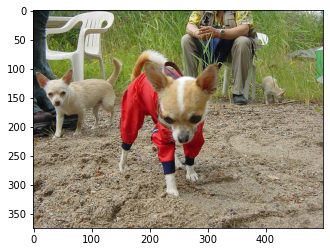

In [17]:
show_image(image_path=data_example_path)

Display the first batch of images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


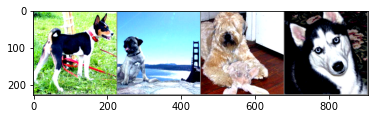

Image 1 label: basenji
Image 2 label: pug
Image 3 label: soft
Image 4 label: Siberian_husky


In [18]:
# Get some random training images
dataiter = iter(dataloaders["val"])
images, labels = dataiter.next()

# Show images
show_batch_of_images(torchvision.utils.make_grid(images))

# Print labels
for i in range(len(images)):
    print(f"Image {i+1} label: {class_names[labels[i]].split('-')[1]}")

### Register AML Dataset

Register the data as a file dataset to the AML workspace for easy accessibility throughout the ML lifecycle.

In [19]:
# Register the dataset
dataset = dataset.register(workspace=ws,
                           name=dataset_name,
                           tags=dataset_tags,
                           description=dataset_description,
                           create_new_version=True)

Now you should be able to see your registered AML dataset in the AML workspace:
    
<img src="../docs/images/aml_dataset.png" alt="aml_dataset" width="800"/>   